In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.ghostnetv2 import GhostNetV2
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [3]:
artifact_path = Path("../../artifacts/ghostnetv2")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/gtsrb")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = 43

In [9]:
len(train_dataset)

26640

9


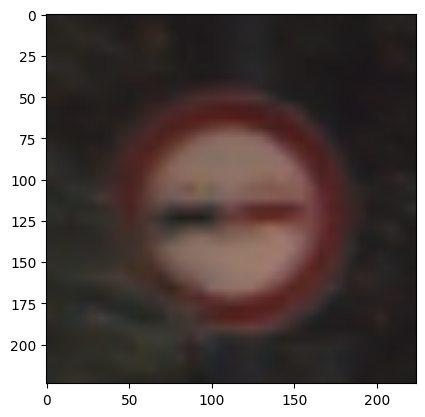

In [10]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [11]:
model = GhostNetV2(output_size=num_class).to(device)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
GhostNetV2                                                        --
├─Conv2dNormActivation: 1-1                                       --
│    └─Conv2d: 2-1                                                432
│    └─BatchNorm2d: 2-2                                           32
│    └─ReLU: 2-3                                                  --
├─Sequential: 1-2                                                 --
│    └─GhostLayerV2: 2-4                                          --
│    │    └─ResBlock: 3-1                                         1,472
│    └─GhostLayerV2: 2-5                                          --
│    │    └─ResBlock: 3-2                                         4,172
│    └─GhostLayerV2: 2-6                                          --
│    │    └─ResBlock: 3-3                                         6,216
│    └─GhostLayerV2: 2-7                                          --
│    │    └─ResBloc

# training

In [13]:
epochs = 10
acc_iters = 256 / BATCH_SIZE

In [14]:
trainer = ClassificationTrainer(epochs, device, acc_iters)

In [15]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [16]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [17]:
training_loss = trainer.run(train_loader, model, optim, criterion, scheduler)

100%|██████████| 416/416 [01:33<00:00,  4.44it/s]


epoch 1 : 0.008179378069493955


100%|██████████| 416/416 [01:30<00:00,  4.58it/s]


epoch 2 : 0.0017896725434044269


100%|██████████| 416/416 [01:32<00:00,  4.50it/s]


epoch 3 : 0.0005468753569962595


100%|██████████| 416/416 [01:41<00:00,  4.11it/s]


epoch 4 : 0.0003274102197547808


100%|██████████| 416/416 [01:44<00:00,  3.99it/s]


epoch 5 : 0.00022049504784149576


100%|██████████| 416/416 [01:38<00:00,  4.21it/s]


epoch 6 : 0.0001745027317613134


100%|██████████| 416/416 [01:30<00:00,  4.58it/s]


epoch 7 : 0.000129707607188633


100%|██████████| 416/416 [01:26<00:00,  4.81it/s]


epoch 8 : 0.00010125346861728373


100%|██████████| 416/416 [01:27<00:00,  4.75it/s]


epoch 9 : 0.00010719965442700204


100%|██████████| 416/416 [01:26<00:00,  4.80it/s]

epoch 10 : 0.00014470513145535226


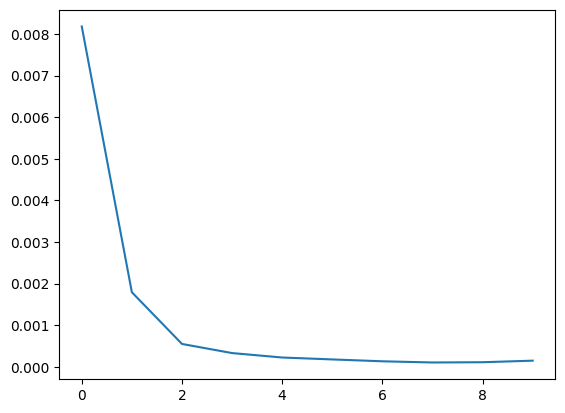

In [18]:
plt.plot(training_loss)

# inference

In [19]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [20]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [21]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [22]:
evaluator = ClassificationEvaluator(num_class, device)

In [23]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 198/198 [00:24<00:00,  7.93it/s]

[[ 60   0   0 ...   0   0   0]
 [  0 700  15 ...   0   0   0]
 [  0   0 737 ...   0   0   0]
 ...
 [  0   0   0 ...  79   0   0]
 [  0   0   1 ...   0  53   0]
 [  0   0   0 ...   0   9  65]]


In [24]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 1.0
1         : 0.9722222222222222
2         : 0.9826666666666667
3         : 0.9755555555555555
4         : 0.9772727272727273
5         : 0.9349206349206349
6         : 0.8666666666666667
7         : 0.9888888888888889
8         : 0.8666666666666667
9         : 1.0
10        : 0.9893939393939394
11        : 0.9809523809523809
12        : 0.9681159420289855
13        : 0.9930555555555556
14        : 0.9925925925925926
15        : 0.9380952380952381
16        : 0.98
17        : 0.8611111111111112
18        : 0.9384615384615385
19        : 0.8833333333333333
20        : 0.5111111111111111
21        : 0.5444444444444444
22        : 0.775
23        : 0.7533333333333333
24        : 0.6888888888888889
25        : 0.93125
26        : 0.9888888888888889
27        : 0.8333333333333334
28        : 0.9066666666666666
29        : 0.9888888888888889
30        : 0.6933333333333334
31        : 0.9851851851851852
32        : 0.9833333333333333
33        : 0.8952380952380953
34        : 0.

In [25]:
per_class_acc.mean()

0.8848549561044505

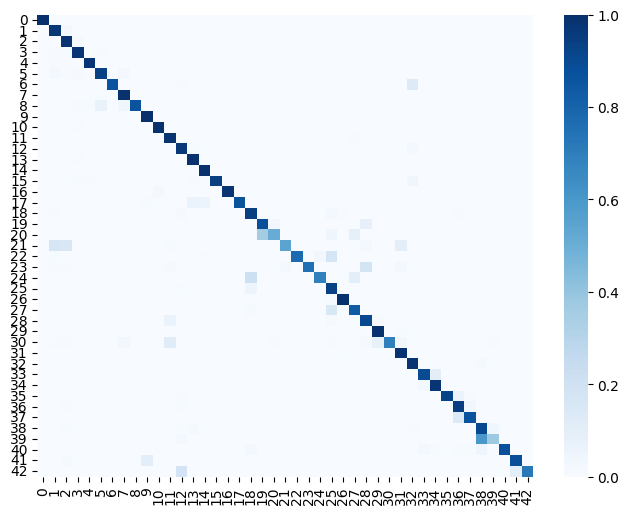

In [26]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [27]:
model_path = artifact_path / f'ghostnetv2.pth'

In [28]:
torch.save(model.state_dict(), model_path)

In [29]:
get_file_size(model_path)

'20.04MiB'

In [30]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>